In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import torch
import zarr

## ViT

In [2]:
from src.models.vit import vit_base_patch16

In [6]:
wts = "/data/pulkitag/models/ankile/furniture-diffusion/mae/mae_pretrain_vit_base.pth"

state_dict = torch.load(wts, map_location="cpu")

In [8]:
state_dict.keys()

dict_keys(['model'])

In [4]:
vit = vit_base_patch16()

In [10]:
vit.load_state_dict(state_dict["model"], strict=False)

_IncompatibleKeys(missing_keys=['head.weight', 'head.bias'], unexpected_keys=[])

In [11]:
vit.forward_features(torch.randn(1, 3, 224, 224)).shape

torch.Size([1, 768])

## Spatial SoftMax Resnet

In [21]:
from src.models.vision import SpatialSoftmaxEncoder

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
enc = SpatialSoftmaxEncoder(
    device="cpu",
    freeze=False,
    use_groupnorm=True,
)

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [27]:
img = torch.randint(0, 255, (1, 224, 224, 3))

In [28]:
enc(img).mean()

tensor(-0.0005, grad_fn=<MeanBackward0>)

## Voltron

In [6]:
# Get an image from a zarr dataset
ds = zarr.open(
    "/data/scratch/ankile/furniture-data/processed/sim/image/lamp/teleop.zarr"
)

raw_img1 = ds["color_image2"][0]
raw_img2 = ds["color_image2"][800]

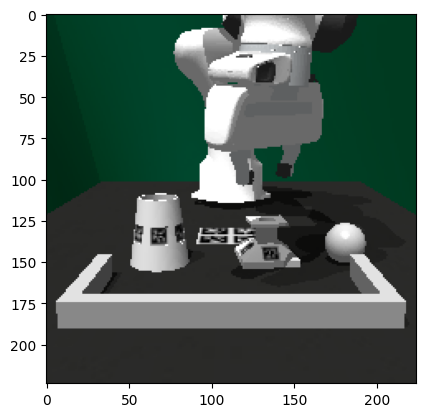

In [7]:
from matplotlib import pyplot as plt


plt.imshow(raw_img1)

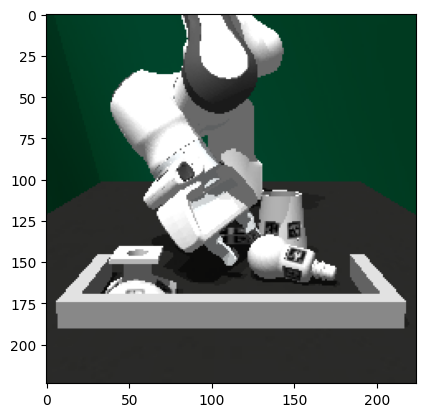

In [8]:
plt.imshow(raw_img2)

In [9]:
from voltron import instantiate_extractor, load

# Load a frozen Voltron (V-Cond) model & configure a vector extractor
vcond, preprocess = load(
    "v-cond", device="cuda", freeze=True, cache="/data/scratch/ankile/.voltron"
)
vector_extractor = instantiate_extractor(vcond)().to("cuda")

In [11]:
from src.common.tasks import simple_task_descriptions, complex_task_descriptions

In [ ]:
representations = []

In [16]:
# Obtain & Preprocess an image =>> can be from a dataset, or camera on a robot, etc.
#   => Feel free to add any language if you have it (Voltron models work either way!)
img1 = preprocess(torch.from_numpy(raw_img1).reshape((3, 224, 224)))[None, ...].to(
    "cuda"
)
img2 = preprocess(torch.from_numpy(raw_img2).reshape((3, 224, 224)))[None, ...].to(
    "cuda"
)
# lang = complex_task_descriptions["lamp"]
lang = simple_task_descriptions["lamp"]

/data/scratch/ankile/miniconda3/envs/rlgpu/lib/python3.8/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [17]:
representations1 = []

for desc in lang:
    # # Extract both multimodal AND vision-only embeddings!
    with torch.no_grad():
        multimodal_embeddings = vcond(img1, [desc], mode="multimodal")
        # visual_embeddings = vcond(img, mode="visual")

        # # Use the `vector_extractor` to output dense vector representations for downstream applications!
        # #   => Pass this representation to model of your choice (object detector, control policy, etc.)
        representation = vector_extractor(multimodal_embeddings).cpu().numpy()

    representations1.append(representation.squeeze())

representations2 = []

for desc in lang:
    # # Extract both multimodal AND vision-only embeddings!
    with torch.no_grad():
        multimodal_embeddings = vcond(img2, [desc], mode="multimodal")
        # visual_embeddings = vcond(img, mode="visual")

        # # Use the `vector_extractor` to output dense vector representations for downstream applications!
        # #   => Pass this representation to model of your choice (object detector, control policy, etc.)
        representation = vector_extractor(multimodal_embeddings).cpu().numpy()

    representations2.append(representation.squeeze())

Text(0.5, 1.0, 'PCA of V-Cond representations w/ Simple descriptions')

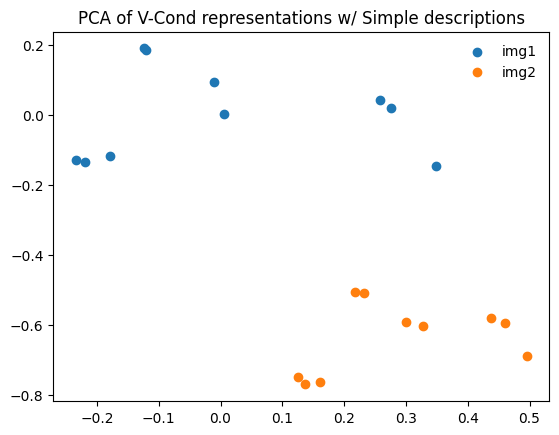

In [18]:
# Use simple dimensionality reduction to visualize the representations
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# Get the representations for each description with fit_transform for both images
reduced1 = pca.fit_transform(representations1)
reduced2 = pca.transform(representations2)

# Plot the representations
plt.scatter(reduced1[:, 0], reduced1[:, 1], label="img1")
plt.scatter(reduced2[:, 0], reduced2[:, 1], label="img2")

plt.legend(frameon=False)
# plt.axis("off")
plt.title("PCA of V-Cond representations w/ Simple descriptions")

In [5]:
from src.models.vision import VoltronEncoder, MAEEncoder

In [2]:
enc = VoltronEncoder(
    device="cuda",
    freeze=False,
)

In [14]:
# Count number of parameters
f"{sum(p.numel() for p in enc.model.parameters() if p.requires_grad):,}"

'32,762,688'

In [6]:
mae = MAEEncoder(
    device="cuda",
    freeze=False,
)

In [7]:
# Count number of parameters
f"{sum(p.numel() for p in mae.parameters() if p.requires_grad):,}"

'86,567,656'